In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import math
# Ignore sklearn warning for now
import warnings
warnings.filterwarnings('ignore') 
# sns.set() # Setting seaborn as default style even if use only matplotlib
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
# matplotlib.style.use('classic')
from os import listdir
from os.path import isfile, join
import pathlib
import glob
import nibabel as nib
import scipy.ndimage as ndi
import pingouin as pg

# Summary

This notebook explores Cerebral Blood Flow values in grey and white matter with age and their correlation with cognitive scores

In [ ]:
CBF_cog_data = pd.read_csv('CBF_cog_data_3101_last.csv')

In [3]:
CBF_cog_data.insert(2, 'Q', np.nan)

In [4]:
# group data into age quartiles
for i in range(CBF_cog_data.shape[0]):
    if CBF_cog_data['age'][i]<30: # 17-29
        CBF_cog_data['Q'][i] = 'Q1'
    if CBF_cog_data['age'][i]>=30: # 30-39
        if CBF_cog_data['age'][i]<40:
            CBF_cog_data['Q'][i] = 'Q2'
    if CBF_cog_data['age'][i]>=40: # 40-58
        CBF_cog_data['Q'][i] = 'Q3'

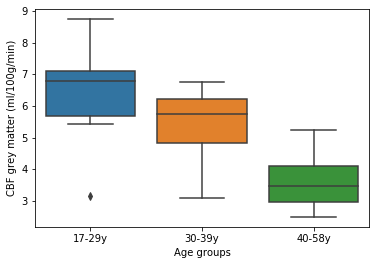

In [8]:
CBF_cog_data = pd.read_csv('CBF_cog_data_Q_3_years - Copy.csv')

sns.boxplot( x=CBF_cog_data["Q"], y=CBF_cog_data["CBF_gm_avg"] )
plt.xlabel('Age groups')
plt.ylabel('CBF grey matter (ml/100g/min)')
#plt.savefig('CBF_gm_avg_age_groups_last.png', dpi = 400, bbox_inches='tight')

# statistical annotation - from Shapiro- Wilk + one way ANOVA 
x1, x2 = 0, 2   # A-C
y, h, col = CBF_cog_data_Q["CBF_gm_avg_x10"].max() + 3.5, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col)

x3, x4 = 1, 2   # A-C
y, h, col = CBF_cog_data_Q["CBF_gm_avg_x10"].max() - 5  , 2, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x3+x4)*.5, y+h, "**", ha='center', va='bottom', color=col)
# plt.savefig('CBF_gm_avg_age_groups_13_03_last.png', dpi = 400, bbox_inches='tight')

plt.ylim([21, 99])
plt.show()

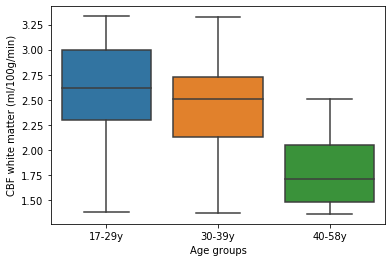

In [16]:
# CBF_cog_data_Q = pd.read_csv('CBF_cog_data_Q_3_years.csv')
sns.boxplot( x=CBF_cog_data["Q"], y=CBF_cog_data["CBF_wm_avg"] )
plt.xlabel('Age groups')
plt.ylabel('CBF white matter (ml/100g/min)')
# plt.savefig('CBF_wm_avg_age_groups_last.png', dpi = 400, bbox_inches='tight')
plt.show()

In [19]:
# age as a covariate
rho2 =pg.partial_corr(data=CBF_cog_data, x='CBF_gm_avg', y='srt_mean_lat', covar='age',method='spearman')
rho2

,n,r,CI95%,p-val
spearman,18,-0.132601,"[-0.58, 0.37]",0.611919


In [22]:
# age and sex as covariates
mat = pg.pairwise_corr(data=CBF_cog_data, covar=['age','sex'],method='spearman')
mat

,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,VF_raw,tol_tot,spearman,"['age', 'sex']",two-sided,31,0.533927,"[0.21, 0.75]",2.853008e-03
1,VF_raw,srt_tot,spearman,"['age', 'sex']",two-sided,22,0.318205,"[-0.14, 0.67]",1.715375e-01
2,VF_raw,srt_mean_lat,spearman,"['age', 'sex']",two-sided,22,-0.247789,"[-0.62, 0.22]",2.921888e-01
3,VF_raw,srt_lat_sd,spearman,"['age', 'sex']",two-sided,27,0.246406,"[-0.16, 0.58]",2.350808e-01
4,VF_raw,pal_first,spearman,"['age', 'sex']",two-sided,30,0.310490,"[-0.07, 0.61]",1.078163e-01
...,...,...,...,...,...,...,...,...,...
205,kbit2_nv,kbit_nviq,spearman,"['age', 'sex']",two-sided,37,0.971378,"[0.94, 0.99]",3.551385e-22
206,kbit2_nv,kbit_tiq,spearman,"['age', 'sex']",two-sided,36,0.815309,"[0.66, 0.9]",4.312653e-09
207,kbit_viq,kbit_nviq,spearman,"['age', 'sex']",two-sided,36,0.448364,"[0.13, 0.68]",7.827212e-03
208,kbit_viq,kbit_tiq,spearman,"['age', 'sex']",two-sided,36,0.832523,"[0.69, 0.91]",1.028418e-09


In [23]:
mat2 = pg.pairwise_corr(data=CBF_cog_data, columns=['CBF_gm_avg', 'CBF_wm_avg', ' VF_raw', 'tol_tot', 'srt_tot', 'srt_mean_lat', 'srt_lat_sd', 'pal_first', 'pal_stages', 'kbit2_vk', 'kbit2_mat', 'kbit2_rid', 'kbit2_ver', 'kbit2_nv', 'kbit_viq', 'kbit_nviq', 'kbit_tiq'], covar=['age','sex'],method='spearman')
mat2

,X,Y,method,covar,alternative,n,r,CI95%,p-unc
0,CBF_gm_avg,CBF_wm_avg,spearman,"['age', 'sex']",two-sided,33,0.916930,"[0.83, 0.96]",4.283030e-13
1,CBF_gm_avg,tol_tot,spearman,"['age', 'sex']",two-sided,25,-0.140636,"[-0.52, 0.29]",5.221430e-01
2,CBF_gm_avg,srt_tot,spearman,"['age', 'sex']",two-sided,18,-0.692847,"[-0.88, -0.3]",2.926579e-03
3,CBF_gm_avg,srt_mean_lat,spearman,"['age', 'sex']",two-sided,18,-0.105096,"[-0.57, 0.41]",6.984909e-01
4,CBF_gm_avg,srt_lat_sd,spearman,"['age', 'sex']",two-sided,22,-0.081819,"[-0.51, 0.37]",7.316578e-01
...,...,...,...,...,...,...,...,...,...
115,kbit2_nv,kbit_nviq,spearman,"['age', 'sex']",two-sided,37,0.971378,"[0.94, 0.99]",3.551385e-22
116,kbit2_nv,kbit_tiq,spearman,"['age', 'sex']",two-sided,36,0.815309,"[0.66, 0.9]",4.312653e-09
117,kbit_viq,kbit_nviq,spearman,"['age', 'sex']",two-sided,36,0.448364,"[0.13, 0.68]",7.827212e-03
118,kbit_viq,kbit_tiq,spearman,"['age', 'sex']",two-sided,36,0.832523,"[0.69, 0.91]",1.028418e-09


In [147]:
mat2.to_csv('partialCorr_reduced_3101_last.csv', index=False)

In [24]:
rho = CBF_cog_data.corrwith(CBF_cog_data['CBF_gm_avg']).sort_values()[::-1][1:]
rho

CBF_gm_min           NaN
CBF_gm_avg      1.000000
CBF_gm_var      0.975485
CBF_wm_avg      0.924466
CBF_wm_var      0.892651
CBF_gm_max      0.632960
kbit_nviq       0.330922
CBF_wm_max      0.259882
kbit_tiq        0.259839
kbit2_mat       0.240281
kbit2_nv        0.240281
pal_stages      0.195275
kbit_viq        0.188348
VF_raw          0.146268
pal_first       0.121211
kbit2_vk        0.084082
srt_tot         0.059555
kbit2_ver       0.049031
kbit2_rid      -0.029699
tol_tot        -0.079791
sex            -0.079810
srt_lat_sd     -0.120756
srt_mean_lat   -0.371837
age            -0.672970
dtype: float64

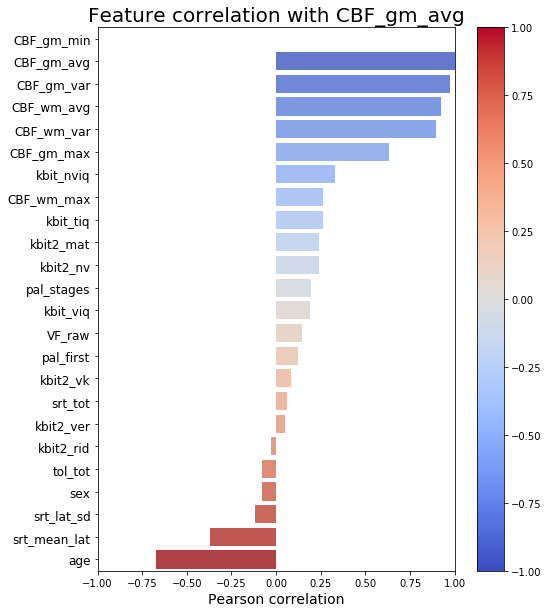

In [25]:
rho = CBF_cog_data.corrwith(CBF_cog_data['CBF_gm_avg']).sort_values()[::-1][1:]
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.figure(figsize=[8, 10])
plt.title("Feature correlation with CBF_gm_avg", fontsize=20)
sns.barplot(x=rho.values.squeeze(), y=rho.index, palette="coolwarm", orient="h")
plt.yticks(fontsize=12)
plt.xlabel("Pearson correlation", fontsize=14)
plt.colorbar(sm)
plt.xlim([-1, 1])
plt.savefig('correlation_CBF_gm_avg.png',dpi = 400, bbox_inches='tight')

In [26]:
CBF_cog_data = CBF_cog_data.drop('CBF_gm_min', axis=1)

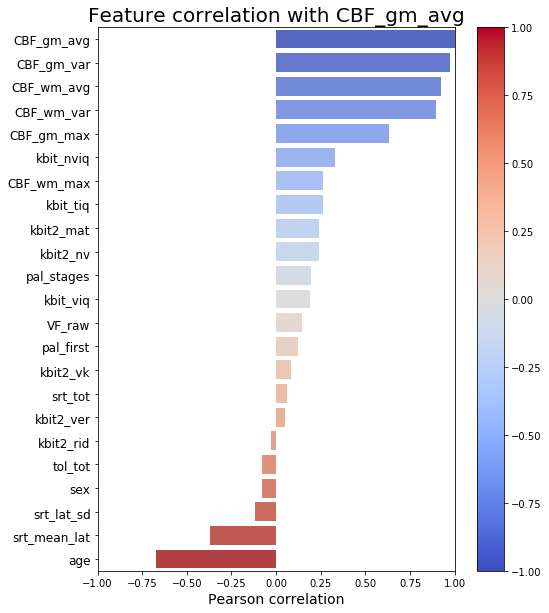

In [27]:
rho = CBF_cog_data.corrwith(CBF_cog_data['CBF_gm_avg']).sort_values()[::-1][1:]
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.figure(figsize=[8, 10])
plt.title("Feature correlation with CBF_gm_avg", fontsize=20)
sns.barplot(x=rho.values.squeeze(), y=rho.index, palette="coolwarm", orient="h")
plt.yticks(fontsize=12)
plt.xlabel("Pearson correlation", fontsize=14)
plt.colorbar(sm)
plt.xlim([-1, 1])
plt.savefig('correlation_CBF_gm_avg.png',dpi = 400, bbox_inches='tight')

## From Fig above, CBF in gm correlates positively with KBIT non-verbal IQ and negatively with simple reaction task (SRT) latency

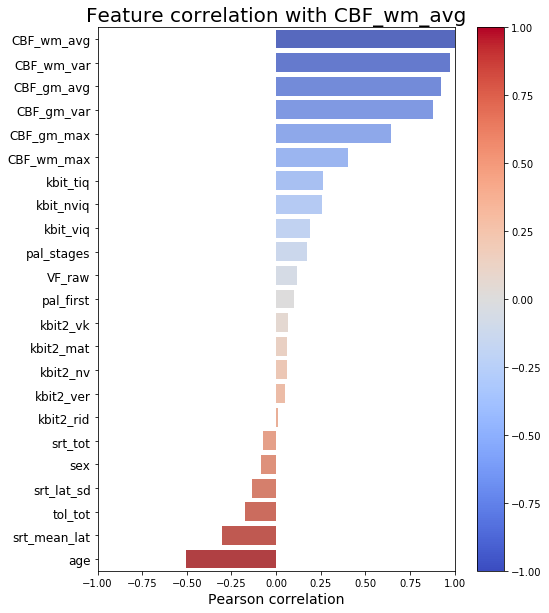

In [28]:
rho = CBF_cog_data.corrwith(CBF_cog_data['CBF_wm_avg']).sort_values()[::-1][1:]
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.figure(figsize=[8, 10])
plt.title("Feature correlation with CBF_wm_avg", fontsize=20)
sns.barplot(x=rho.values.squeeze(), y=rho.index, palette="coolwarm", orient="h")
plt.yticks(fontsize=12)
plt.xlabel("Pearson correlation", fontsize=14)
plt.colorbar(sm)
plt.xlim([-1, 1])
plt.savefig('correlation_CBF_wm_avg.png',dpi = 400, bbox_inches='tight')

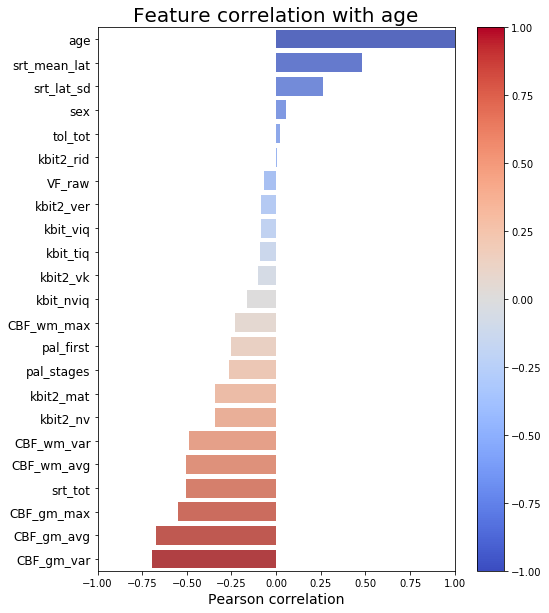

In [29]:
rho = CBF_cog_data.corrwith(CBF_cog_data['age']).sort_values()[::-1][1:]
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.figure(figsize=[8, 10])
plt.title("Feature correlation with age", fontsize=20)
sns.barplot(x=rho.values.squeeze(), y=rho.index, palette="coolwarm", orient="h")
plt.yticks(fontsize=12)
plt.xlabel("Pearson correlation", fontsize=14)
plt.colorbar(sm)
plt.xlim([-1, 1])
plt.savefig('correlation_age.png',dpi = 400, bbox_inches='tight')

Text(0.5, 1.0, 'All participants')

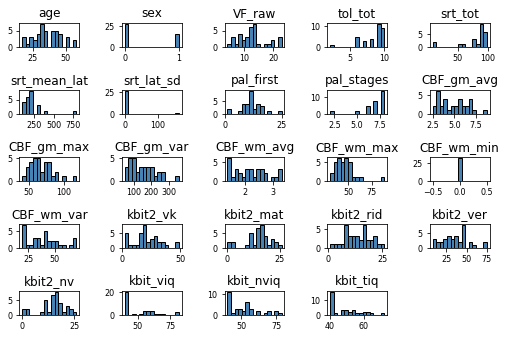

In [30]:
CBF_cog_data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    

plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 
plt.title("All participants")

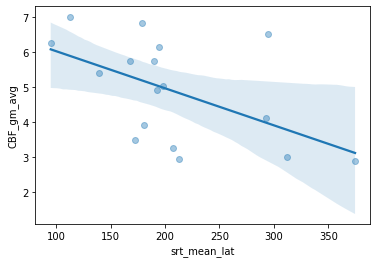

In [43]:
name_x = CBF_cog_data['srt_mean_lat']
name_y1 = CBF_cog_data['CBF_gm_avg']
name_y2 = CBF_cog_data['CBF_wm_avg']
                    

plt.scatter(name_x, name_y1, alpha=0.4)
# plt.scatter(name_x, name_y2, alpha=0.4)
sns.regplot(x= name_x, y=name_y1, data = CBF_cog_data, scatter=False)
# sns.regplot(x= name_x, y=name_y2, data = CBF_cog_data, scatter=False)

plt.xlabel('srt_mean_lat')
plt.ylabel('CBF_gm_avg')
plt.savefig('CBF_gm_avg_srt_mean_lat.png',dpi = 400, bbox_inches='tight')

# plt.legend(['CBF_gm_avg','CBF_wm_avg'])
# plt.title('GFAP and NFL vs num correct animals',y=1.05)
# plt.xlim([0, max(name_x)+1])

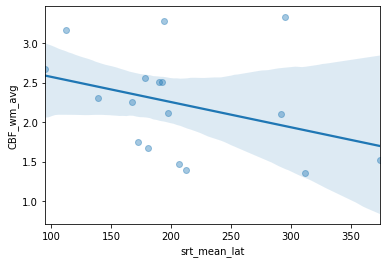

In [41]:
name_x = CBF_cog_data['srt_mean_lat']
name_y1 = CBF_cog_data['CBF_gm_avg']
name_y2 = CBF_cog_data['CBF_wm_avg']
                    

# plt.scatter(name_x, name_y1, alpha=0.4)
plt.scatter(name_x, name_y2, alpha=0.4)
# sns.regplot(x= name_x, y=name_y1, data = CBF_cog_data, scatter=False)
sns.regplot(x= name_x, y=name_y2, data = CBF_cog_data, scatter=False)

plt.xlabel('srt_mean_lat')
plt.ylabel('CBF_wm_avg')
plt.xlim([min(name_x), max(name_x)])
plt.savefig('CBF_wm_avg_srt_mean_lat.png',dpi = 400, bbox_inches='tight')

# plt.legend(['CBF_gm_avg','CBF_wm_avg'])
# plt.title('GFAP and NFL vs num correct animals',y=1.05)
# plt.xlim([0, max(name_x)+1])

# Grey and white matter hypoperfusion with age

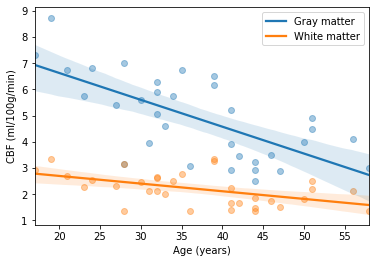

In [44]:
name_x = CBF_cog_data['age']
name_y1 = CBF_cog_data['CBF_gm_avg']
name_y2 = CBF_cog_data['CBF_wm_avg']
                    

plt.scatter(name_x, name_y1, alpha=0.4)
plt.scatter(name_x, name_y2, alpha=0.4)
sns.regplot(x= name_x, y=name_y1, data = CBF_cog_data, scatter=False)
sns.regplot(x= name_x, y=name_y2, data = CBF_cog_data, scatter=False)

plt.xlabel('Age (years)')
plt.ylabel('CBF (ml/100g/min)')
plt.legend(['Grey matter','White matter'])
plt.xlim([min(name_x), max(name_x)])
plt.savefig('CBF_age.png',dpi = 400, bbox_inches='tight')
# plt.title('GFAP and NFL vs num correct animals',y=1.05)


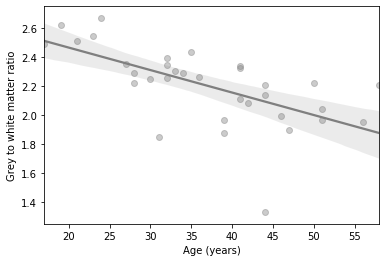

In [45]:
# gm / wm ratio with age
name_x = CBF_cog_data['age']
name_y1 = CBF_cog_data['CBF_gm_avg']
name_y2 = CBF_cog_data['CBF_wm_avg']
                    

plt.scatter(name_x, name_y1/name_y2, alpha=0.4, color = 'tab:gray')
# plt.scatter(name_x, name_y2, alpha=0.4)
sns.regplot(x= name_x, y=name_y1/name_y2, data = CBF_cog_data, scatter=False,color='tab:gray')
# sns.regplot(x= name_x, y=name_y2, data = CBF_cog_data, scatter=False)

plt.xlabel('Age (years)')
plt.ylabel('Grey to white matter ratio')
# plt.legend(['CBF_gm_avg','CBF_wm_avg'])
plt.xlim([min(name_x), max(name_x)])
plt.savefig('CBF_ratio_age.png',dpi = 400, bbox_inches='tight')
# plt.title('GFAP and NFL vs num correct animals',y=1.05)


In [46]:
def VF_linear_reg(name_x, name_y):
    
    x = CBF_cog_data[name_x].values.reshape(-1, 1)
    y = CBF_cog_data[name_y].values.reshape(-1, 1)

    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])

    print(f"slope: {slope}")
    print(f"intercept: {intercept}")
    print(f"r_value: {r_value}")
    print(f"p_value: {p_value}")
    print(f"std_err: {std_err}")
    
    sns.regplot(x= name_x, y=name_y, data = CBF_cog_data, x_jitter=0.1)
    plt.ylabel(name_y + ' (pg/ml)')
    plt.show()
#     plt.savefig('test.png',dpi = 400, bbox_inches='tight')
    
    return [slope, intercept, r_value, p_value, std_err]

slope: -0.10260074419324516
intercept: 8.6823598792117
r_value: -0.6729698158232698
p_value: 1.7791710429926106e-05
std_err: 0.02025405805585165


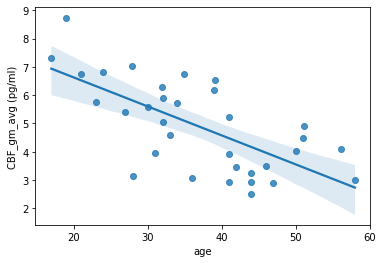

[-0.10260074419324516,
 8.6823598792117,
 -0.6729698158232698,
 1.7791710429926106e-05,
 0.02025405805585165]

In [47]:
name_x ='age'
name_y = 'CBF_gm_avg'
name='CBF_gm_avg vs age'

VF_linear_reg(name_x, name_y)

slope: -0.029245071097178818
intercept: 3.2850131574293773
r_value: -0.5028296516888984
p_value: 0.002860077749083307
std_err: 0.009029390628233781


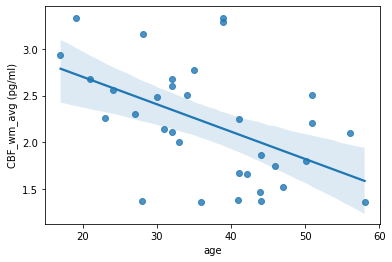

[-0.029245071097178818,
 3.2850131574293773,
 -0.5028296516888984,
 0.002860077749083307,
 0.009029390628233781]

In [48]:
name_x ='age'
name_y = 'CBF_wm_avg'
name='CBF_wm_avg vs age'

VF_linear_reg(name_x, name_y)